In [4]:
import time
import hashlib
import os
import json
import math

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.axes_grid import ImageGrid
from PIL import Image
from IPython import display

#plt.figure(figsize=(15, 15))
%matplotlib inline

In [134]:
data_labels_file = 'skycam_labels.json'
with open(data_labels_file, 'r') as f:
    labels = json.load(f)

In [117]:
# Plotting routines
def make_img_grid(skycam_df, label, cols=8, rows_per_plot=8):
    """Grid of all images labeled as label"""
    img_uid_to_data = get_img_uid_to_data(skycam_df)
    data_with_given_label = labeled_data.loc[(labeled_data.label == label), 'img_uid']
    imgs = [img_uid_to_data(img_uid) for img_uid in data_with_given_label]
    if len(imgs) == 0:
        print(f'No images labeled as "{labels[str(label)]}"')
        return
    else:
        print(f'Images you classified as "{labels[str(label)]}":')
        
    rows = math.ceil(len(imgs) / cols)
    num_subplots = rows_per_plot * cols
    
    for plot_idx in range(math.ceil(rows / rows_per_plot)):
        fig = plt.figure(figsize=(4. * rows_per_plot, 4. * cols))
        grid = ImageGrid(fig, 111,  # similar to subplot(111)
                         nrows_ncols=(rows_per_plot, cols),  # creates width x height grid of axes
                         axes_pad=0.3,  # pad between axes in inch.
                         )
        for i in range(num_subplots):
            img_idx = plot_idx * num_subplots + i
            if img_idx < len(imgs):
                ax = grid[i]
                img = imgs[img_idx]
                img_uid = data_with_given_label.iloc[img_idx]
                ax.set_title(f'{23}{img_uid[:6]}')
                ax.imshow(img)
        plt.show()
        plt.close()

In [96]:
# Database interface routines

def get_uid(data: str):
    """Returns SHA1 hash of a string input data."""
    data_bytes = data.encode('utf-8')
    data_uid = hashlib.sha1(data_bytes).hexdigest()
    return data_uid


def add_user(user_df, name, verbose=False):
    """Adds """
    user_uid = get_uid(name)
    if not user_df.loc[:, 'user_uid'].str.contains(user_uid).any():
        user_df.loc[len(user_df)] = [user_uid, name]
    elif verbose:
        print(f'An entry for "{name}" already exists')
    return user_uid
        

def add_skycam_img(skycam_df, fname, skycam, verbose=False):
    img_uid = get_uid(fname)
    if not skycam_df.loc[:, 'img_uid'].str.contains(img_uid).any():
        skycam_df.loc[len(skycam_df)] = [img_uid, fname, skycam]
    elif verbose:
        print(f'An entry for "{fname}" already exists')
    return img_uid
        
def add_unlabeled_data(unlabeled_df, img_uid, verbose=False):
    if not unlabeled_df.loc[:, 'img_uid'].str.contains(img_uid).any():
        unlabeled_df.loc[len(unlabeled_df)] = [img_uid, False]
    elif verbose:
        print(f'An entry for "{fname}" already exists')
        
        
def add_labeled_data(labeled_df, unlabeled_df, img_uid, user_uid, label):
    #labeled_df.loc[(labeled_df['img_uid'] == img_uid), ['user_uid', 'label']] = [user_uid, label]
    labeled_df.loc[len(labeled_df)] = [img_uid, user_uid, label]
    unlabeled_df.loc[(unlabeled_df['img_uid'] == img_uid), 'is_labeled'] = True


def init_skycam_df(skycam_df, unlabeled_data_df, img_dir):
    for fname in os.listdir(img_dir):
        if fname[-4:] == '.jpg':
            add_skycam_img(skycam_df, fname, 'SC2')
            add_unlabeled_data(unlabeled_data_df, get_uid(fname))

In [131]:
# Labeling interface functions

def do_simple_plot(n):
    """Plotting routine for debugging the labeling interface."""
    t = np.arange(0.0, 2.0, 0.01)
    s = 1 + np.sin(2 * np.pi * t*n)

    fig, ax = plt.subplots()
    ax.plot(t, s)

    ax.set(xlabel='time (s)', ylabel='voltage (mV)',
           title='About as simple as it gets, folks')
    ax.grid()
    #plt.show()
    plt.close()
    return fig

def get_img_uid_to_data(img_metadata_df):
    imgs = {}
    for i in img_metadata_df.index:
        img_uid, fname = img_metadata_df.loc[i, ['img_uid', 'fname']]
        img = np.asarray(Image.open(f'{img_dir}/{fname}'))
        imgs[img_uid] = img
        
    def img_uid_to_data(img_uid):
        return imgs[img_uid]
    
    return img_uid_to_data



def get_plot_img(skycam_df):
    img_uid_to_data = get_img_uid_to_data(skycam_df)
    
    def plot_img(img_uid):
        imgplot = plt.imshow(img_uid_to_data(img_uid))
        return imgplot
    
    return plot_img



def get_valid_labels_str(valid_labels):
    """
    Params:
        valid_labels: dictionary of image classes and their numeric encoding.
        
    Returns: string describing all valid labels and their encodings.
    """
    s = ""
    for key, val in labels.items():
        s += f"{int(key) + 1}='{val}', "
    return s[:-2]


def get_user_label():
    """Prompts and returns the label a user assigns to a given image."""
    valid_label_str = get_valid_labels_str(labels)
    valid_label = False
    while not valid_label:
        label = input(f"Valid labels:\t{valid_label_str}\nYour label: ")
        if label.isnumeric() and str(int(label) - 1) in labels:
            valid_label = True
            label = int(label) - 1
        elif label == 'exit':
            return 'exit'
        else:
            print(f"\x1b[31mError:\t   '{label}' -->  is not a valid label. "
                  "(To exit the session, type 'exit')\x1b[0m\n")
    return label


def get_progress_str(total_itrs, itr_num, num_symbols=50):
    """Generate status progress bar"""
    num_divisions = min(num_symbols, total_itrs)
    itrs_per_symbol = num_symbols / total_itrs
    prog = int(itr_num*itrs_per_symbol)
    progress_str = '#' * prog + ' ' * (num_symbols - prog)
    msg = f"[{progress_str}]" + f"\t{itr_num} / {total_itrs}\n"
    return msg



def get_label_session(labeled_df, unlabeled_df, skycam_df):
    """Constructor for labeling interface.
    Params:
        df: DataFrame containing metadata about unlabeled data points.
        labeler_name: Name of person doing the labeling.
    """
    data_to_label = unlabeled_df[unlabeled_df.is_labeled == False]
    #print(data_to_label)
    num_imgs = len(data_to_label)
    plot_img = get_plot_img(skycam_df)

    def label_session(user_uid):
        """Labeling interface that displays an image and prompts user for its class."""
        if num_imgs == 0:
            print("All data are labeled! \N{grinning face}")
            return
        num_labeled = 0
        try:
            for i in range(len(data_to_label)):
                img_uid = data_to_label.iloc[i]['img_uid']
                imgplot = plot_img(img_uid)
                # Clear display then show next image to label
                display.clear_output(wait=True)

                plt.show()
                plt.close()

                # Get image label
                progress_str = get_progress_str(num_imgs, i)
                print(progress_str)
                label = get_user_label()
                if label == 'exit':
                    break
                add_labeled_data(labeled_df, unlabeled_df, img_uid, user_uid, label)
                num_labeled += 1
        except KeyboardInterrupt:
            return
        finally:
            display.clear_output(wait=True)
            progress_str = get_progress_str(num_imgs, num_labeled)
            print(progress_str)
            print('Exiting...')
            
    return label_session

In [22]:
# Database formats
user_metadata = pd.DataFrame(columns=['user_uid', 'name'])
skycam_img_metadata = pd.DataFrame(columns=['img_uid', 'fname', 'skycam'])
unlabeled_data = pd.DataFrame(columns=['img_uid', 'is_labeled'])
labeled_data = pd.DataFrame(columns=['img_uid', 'user_uid', 'label'])

In [23]:
img_dir = 'cropped_imgs'
init_skycam_df(skycam_img_metadata, unlabeled_data, img_dir)

In [25]:
# Enter your name below, then run this cell
name = "Nicolas Rault-Wang"
user_uid = add_user(user_metadata, name)

In [140]:
# Run this cell to start labeling
label_session = get_label_session(labeled_data, unlabeled_data, skycam_img_metadata)
label_session(user_uid)

[#############                                     ]	5 / 18

Exiting...


Images you classified as "not_cloudy":


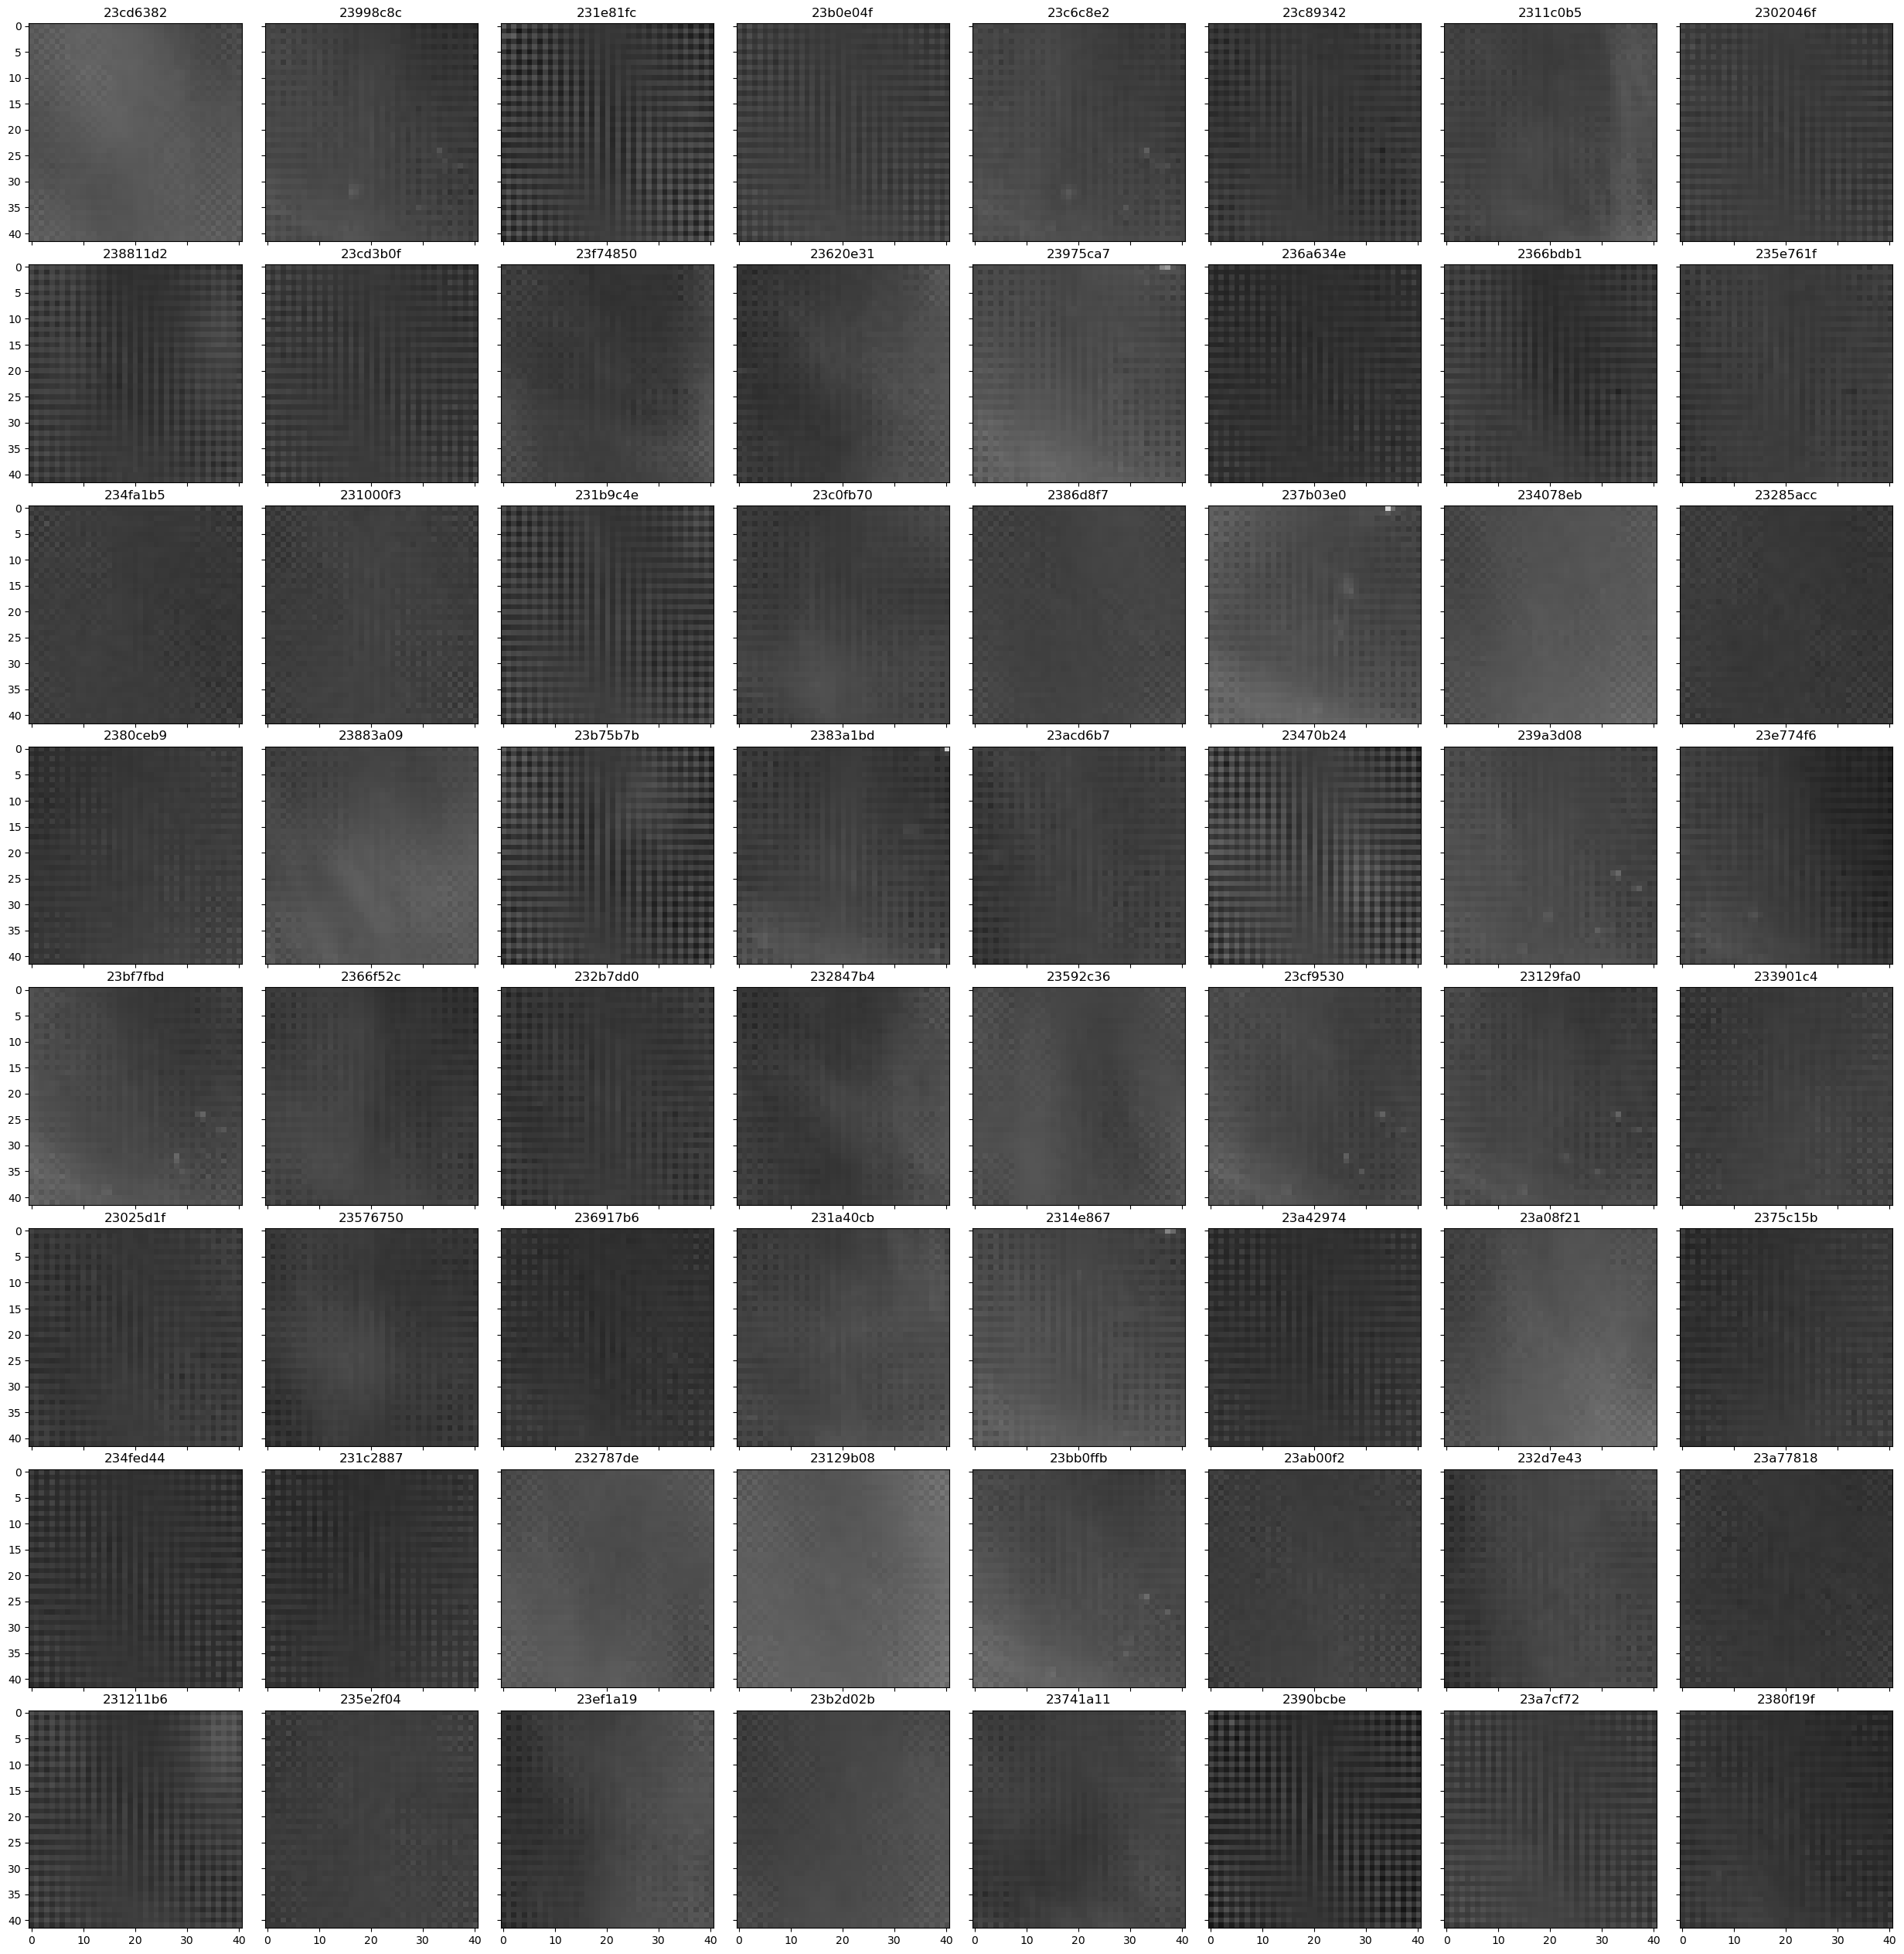

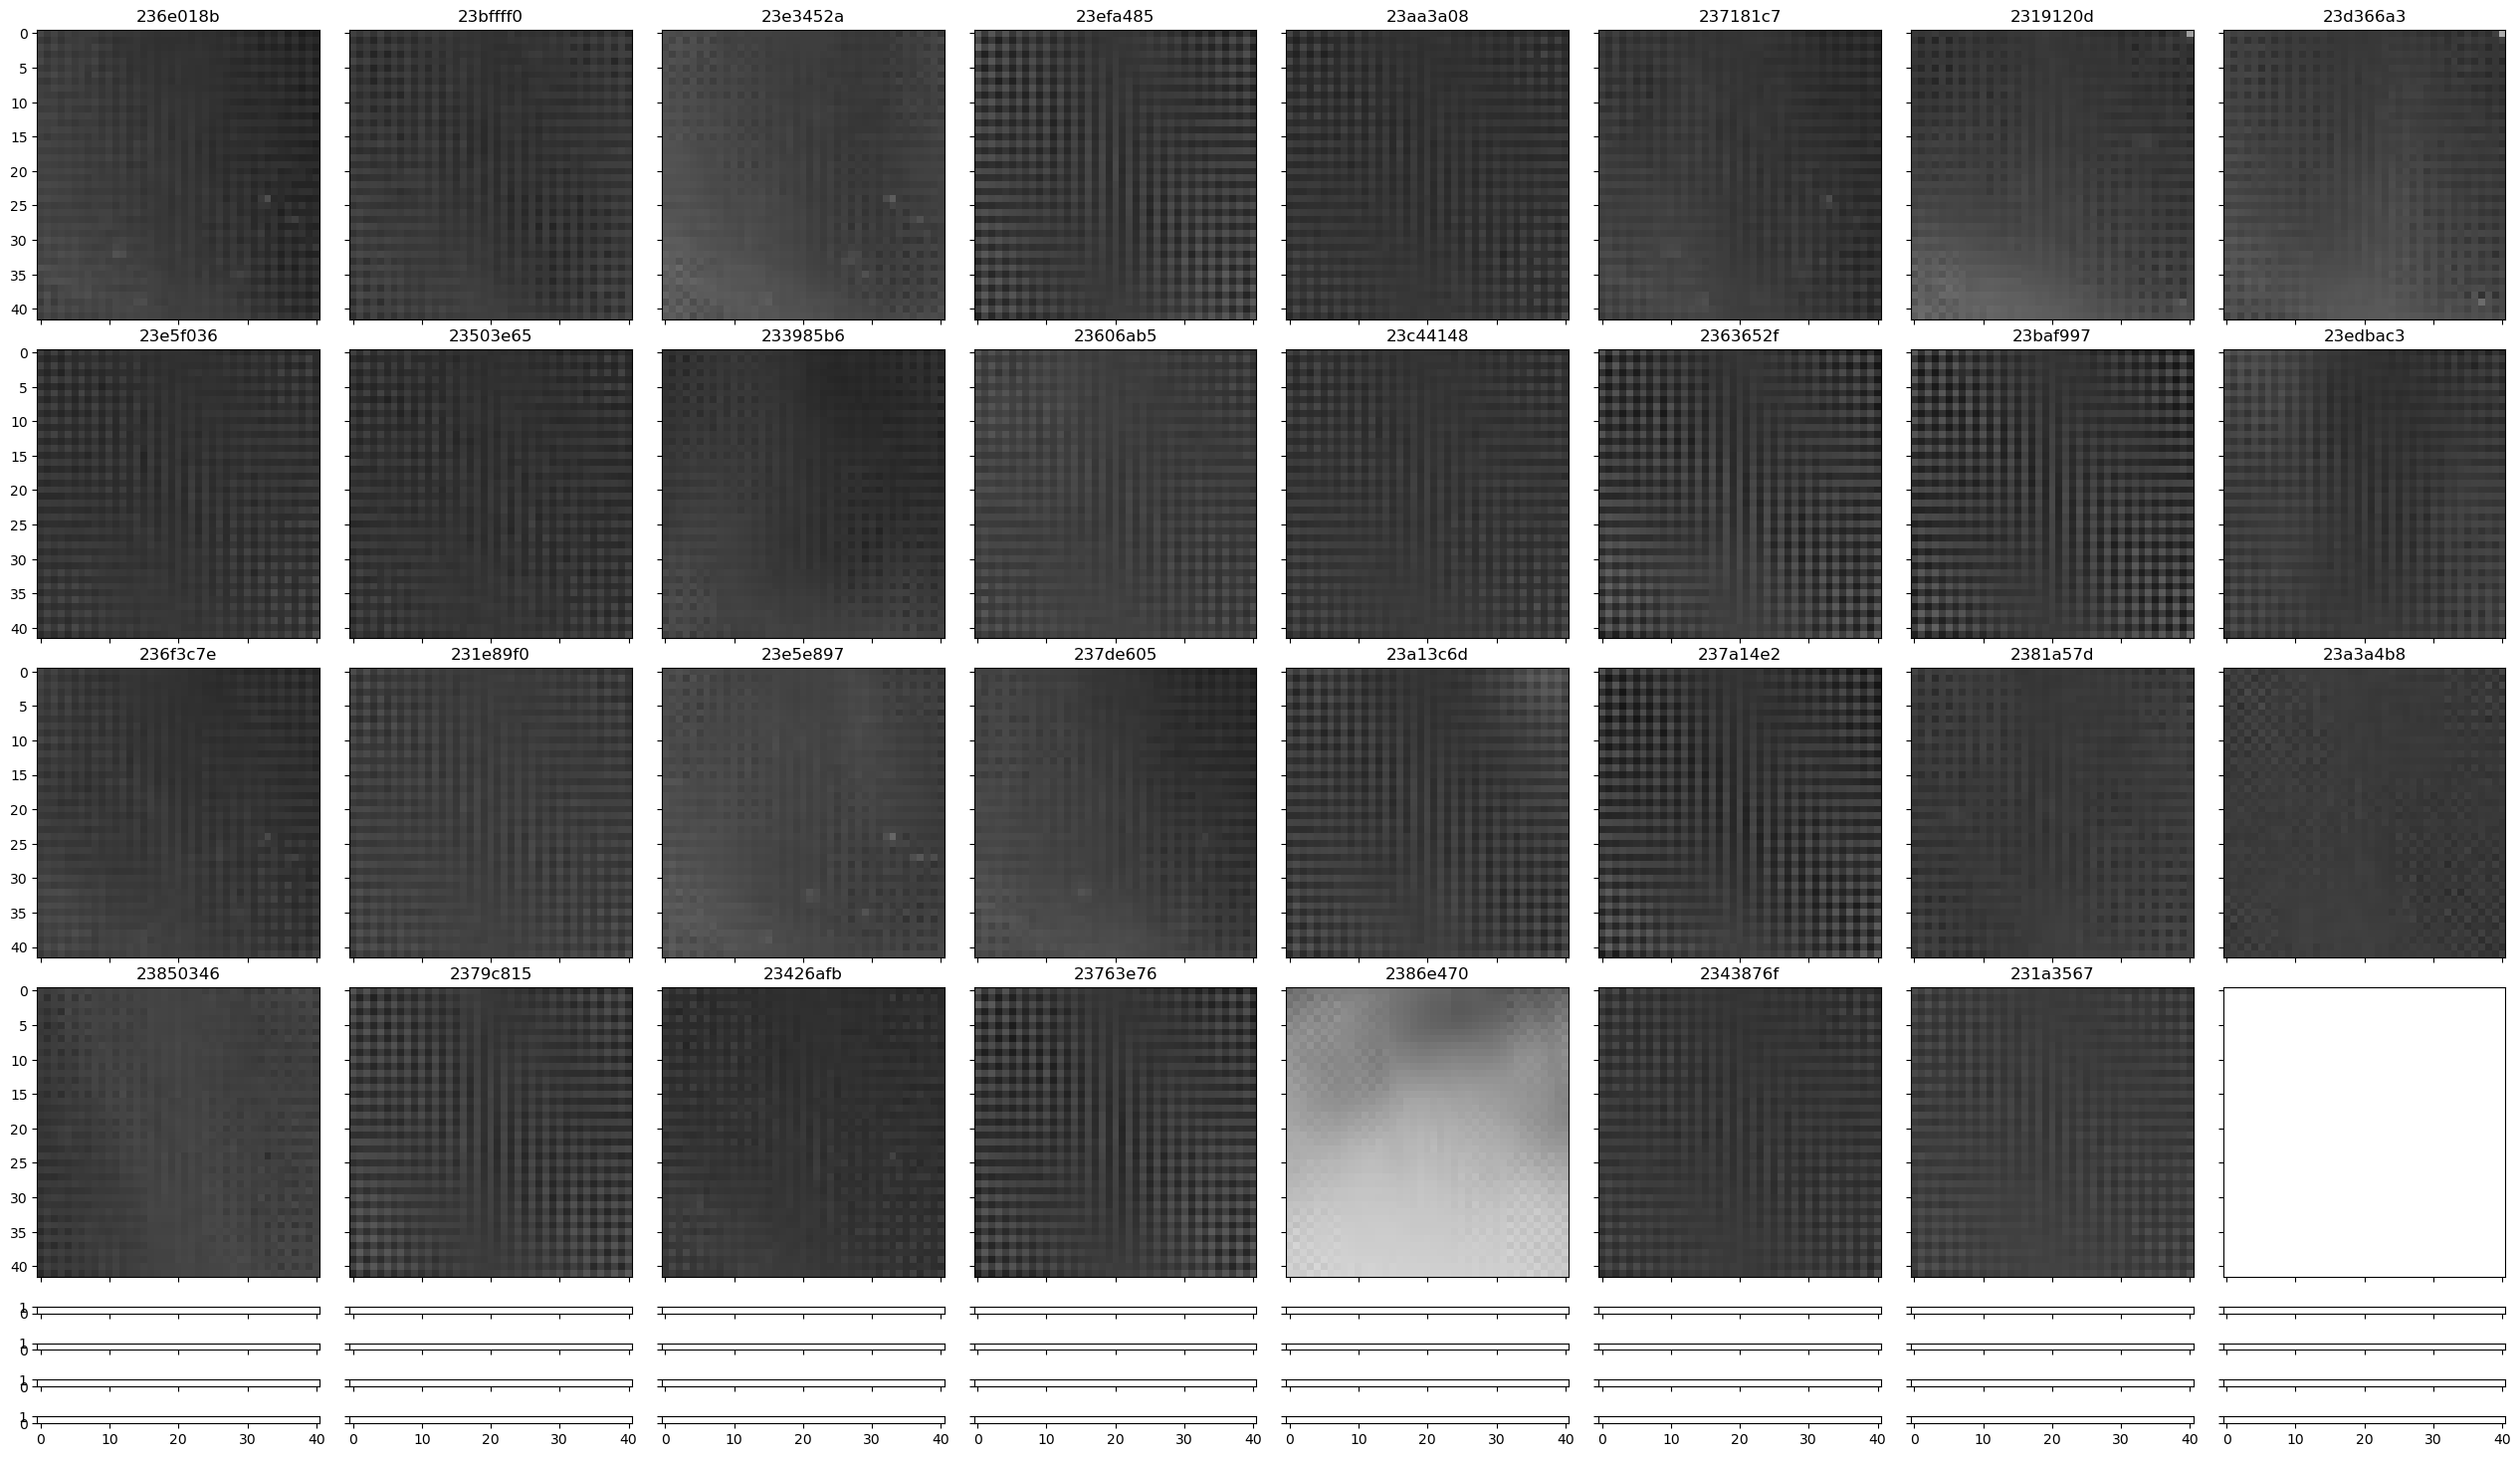

Images you classified as "cloudy":


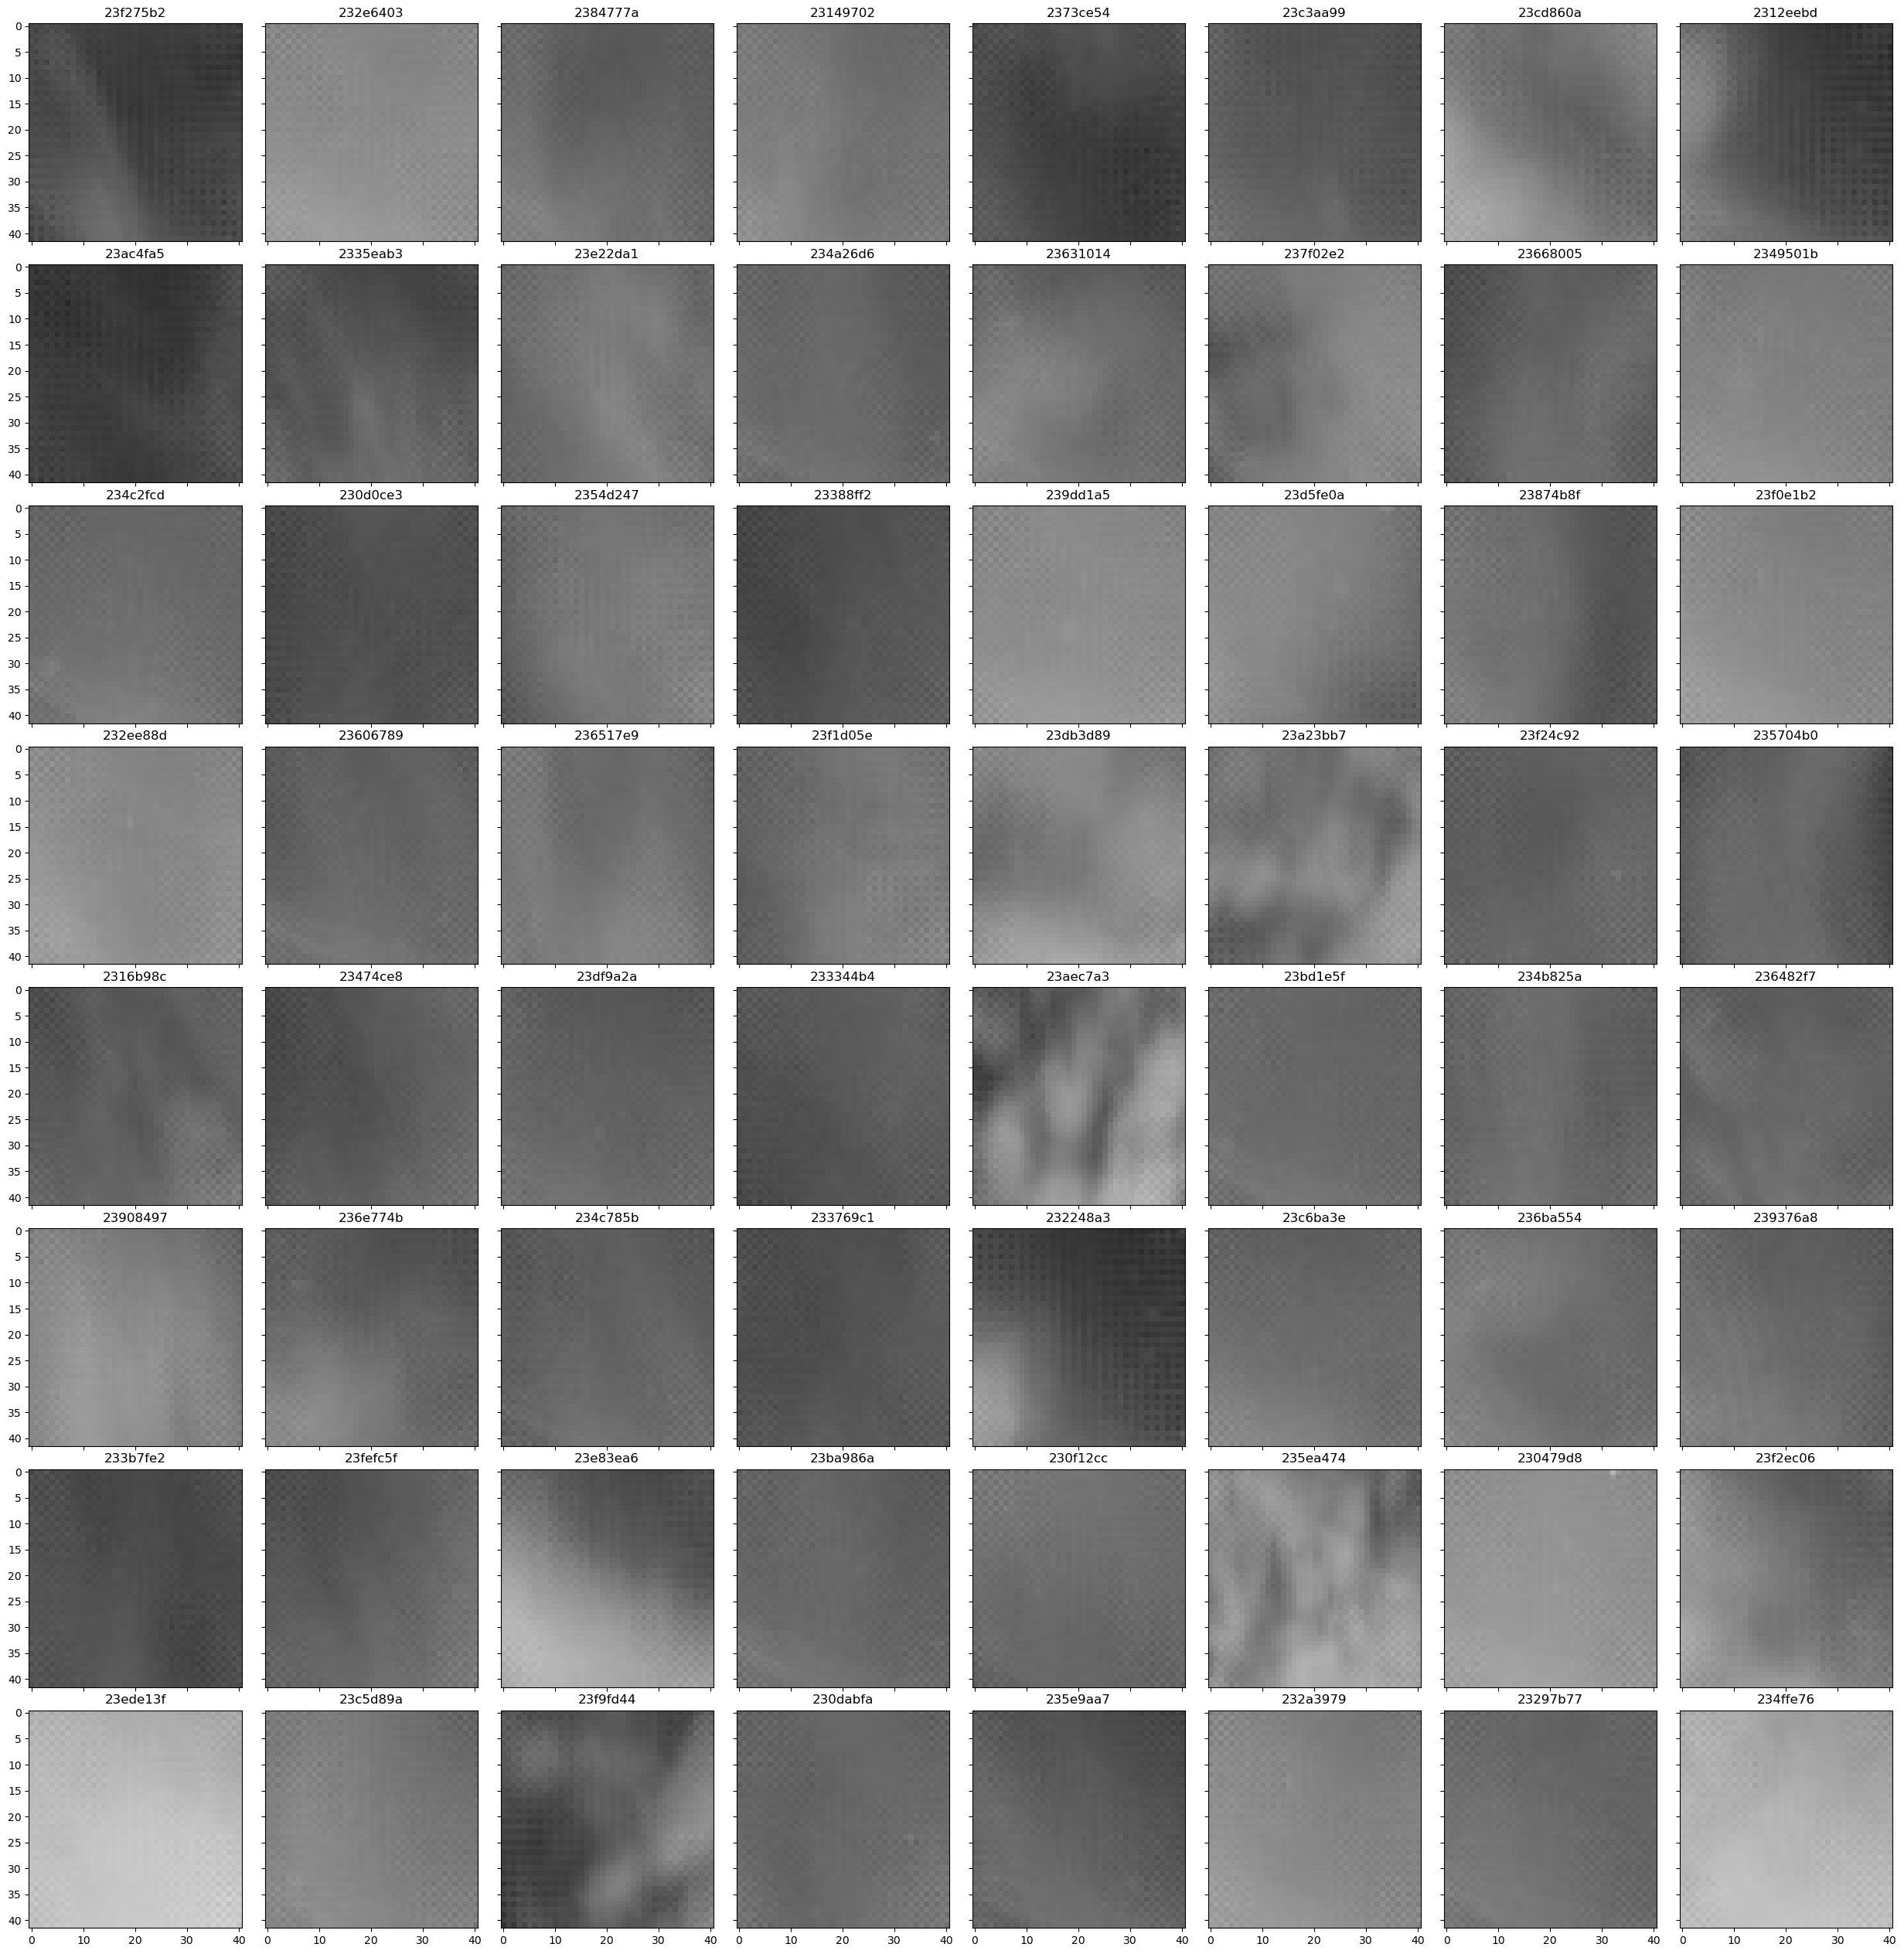

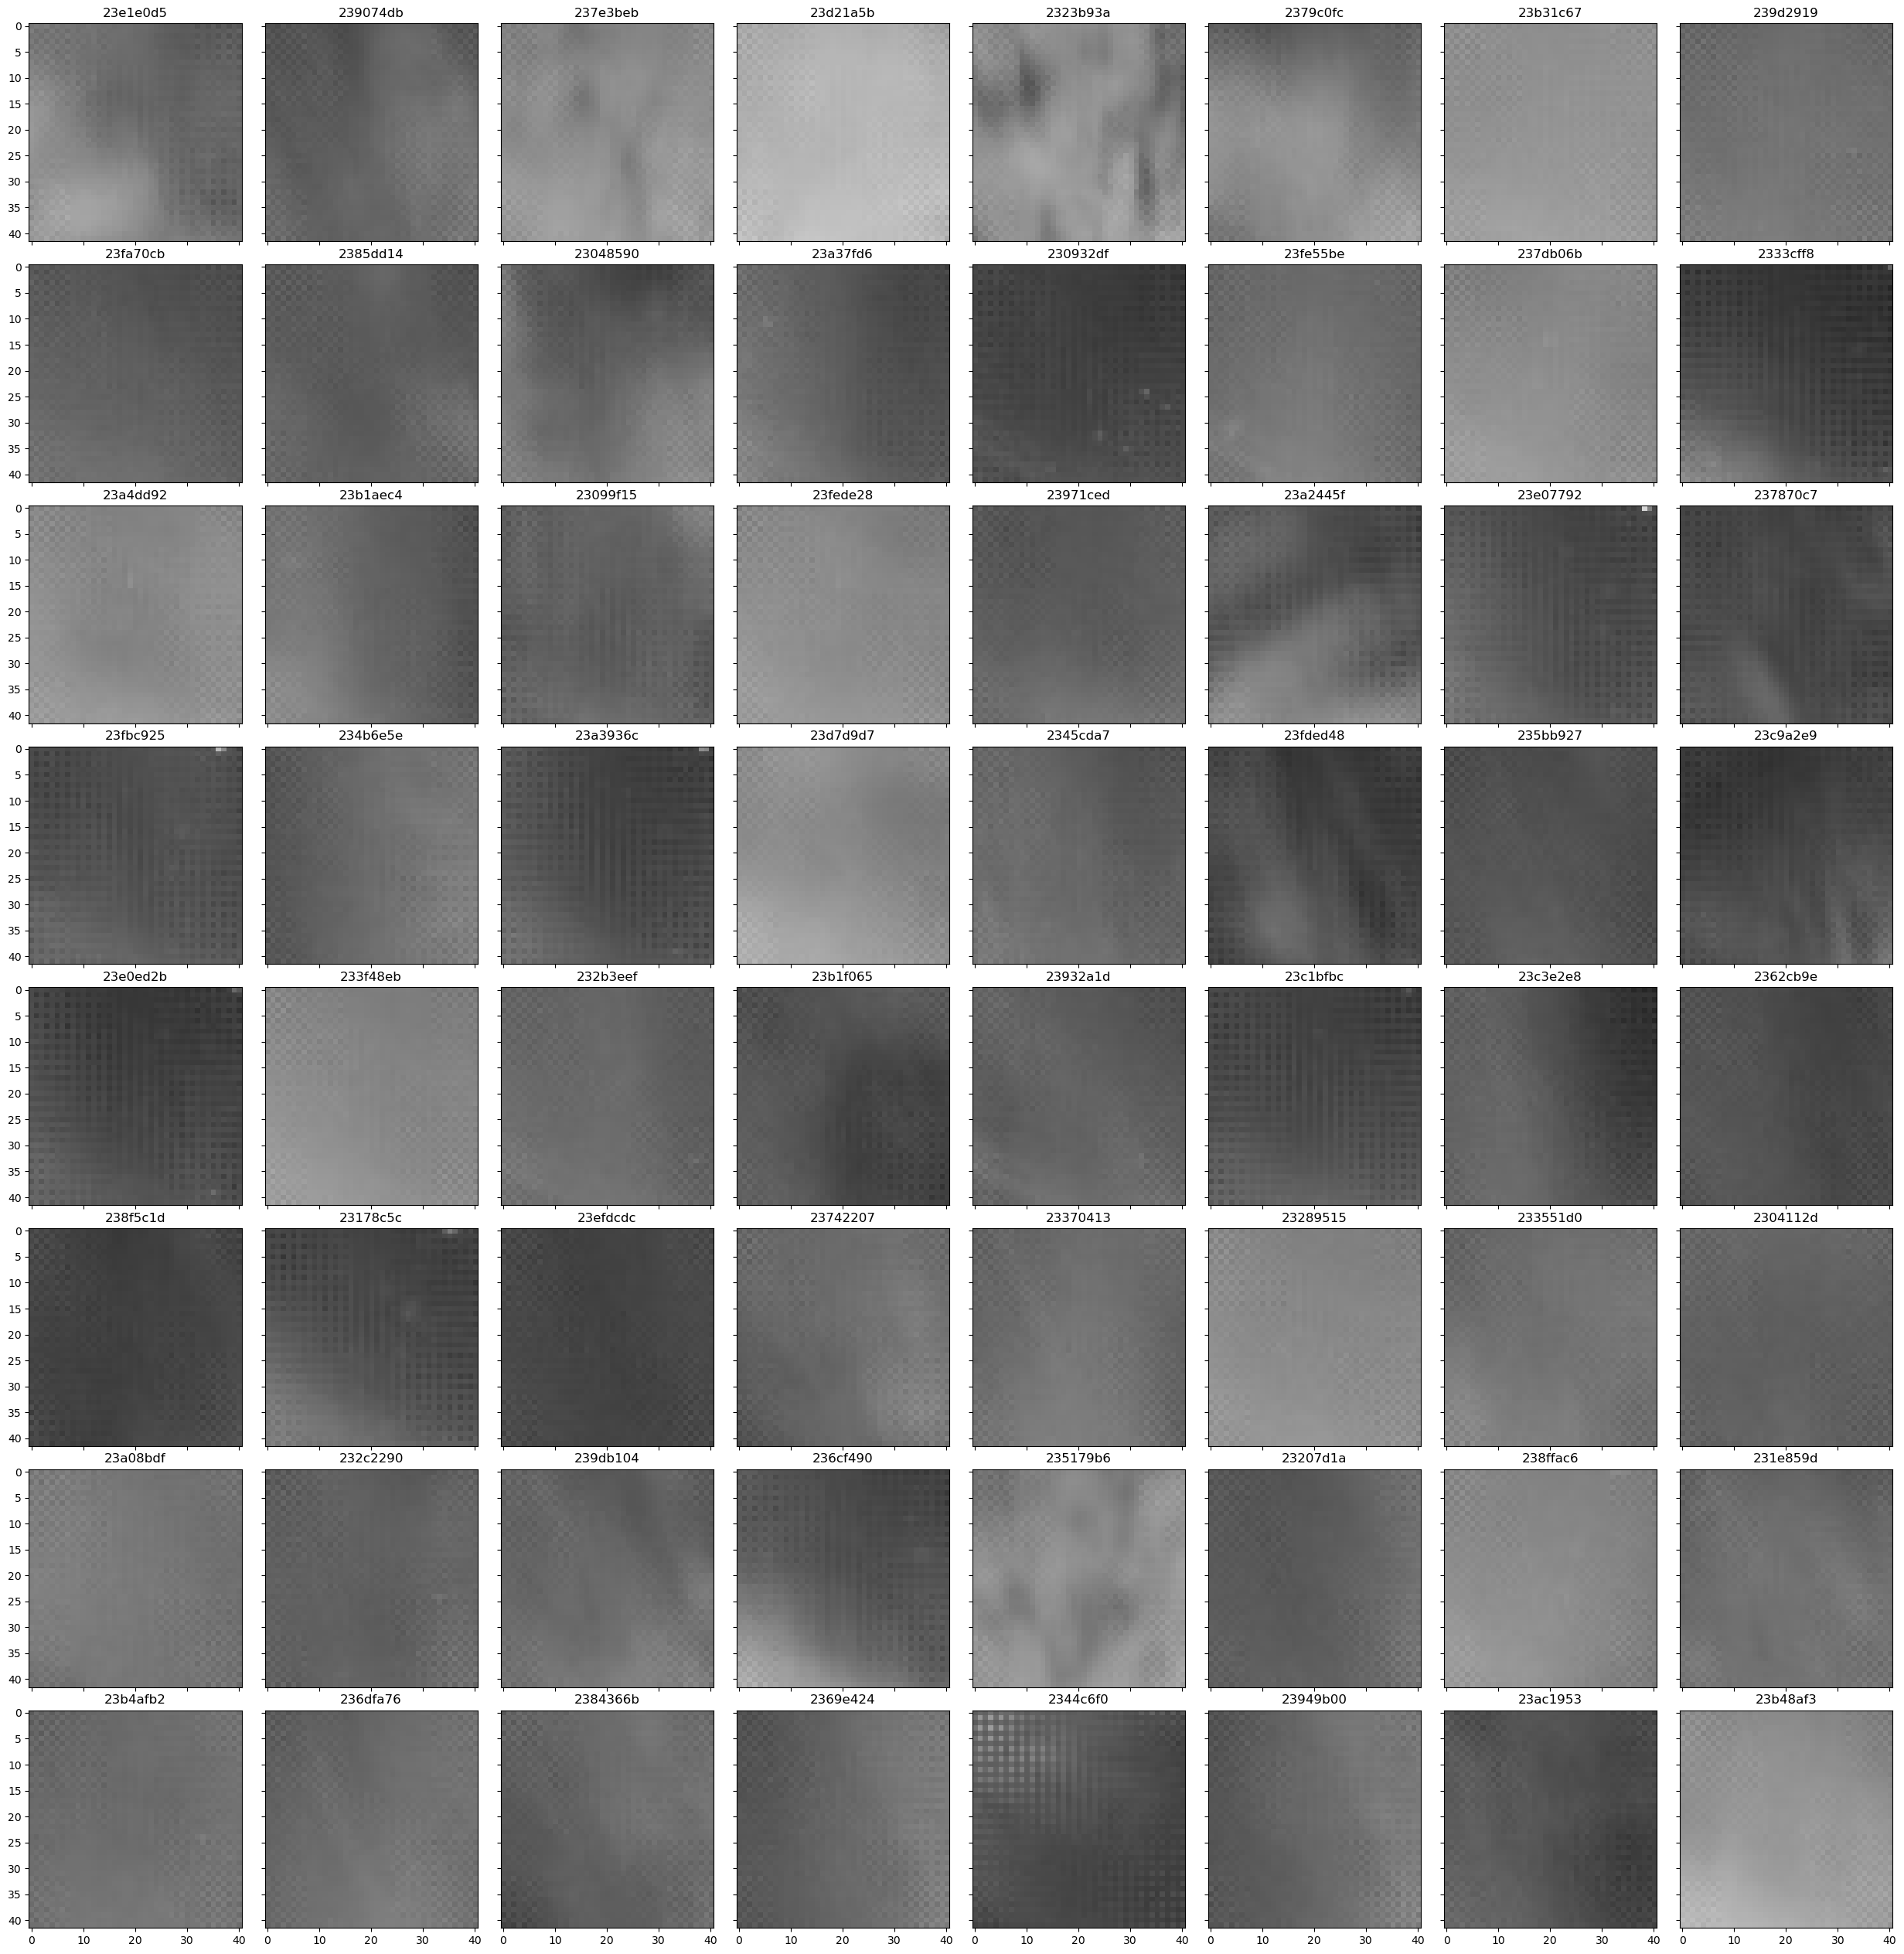

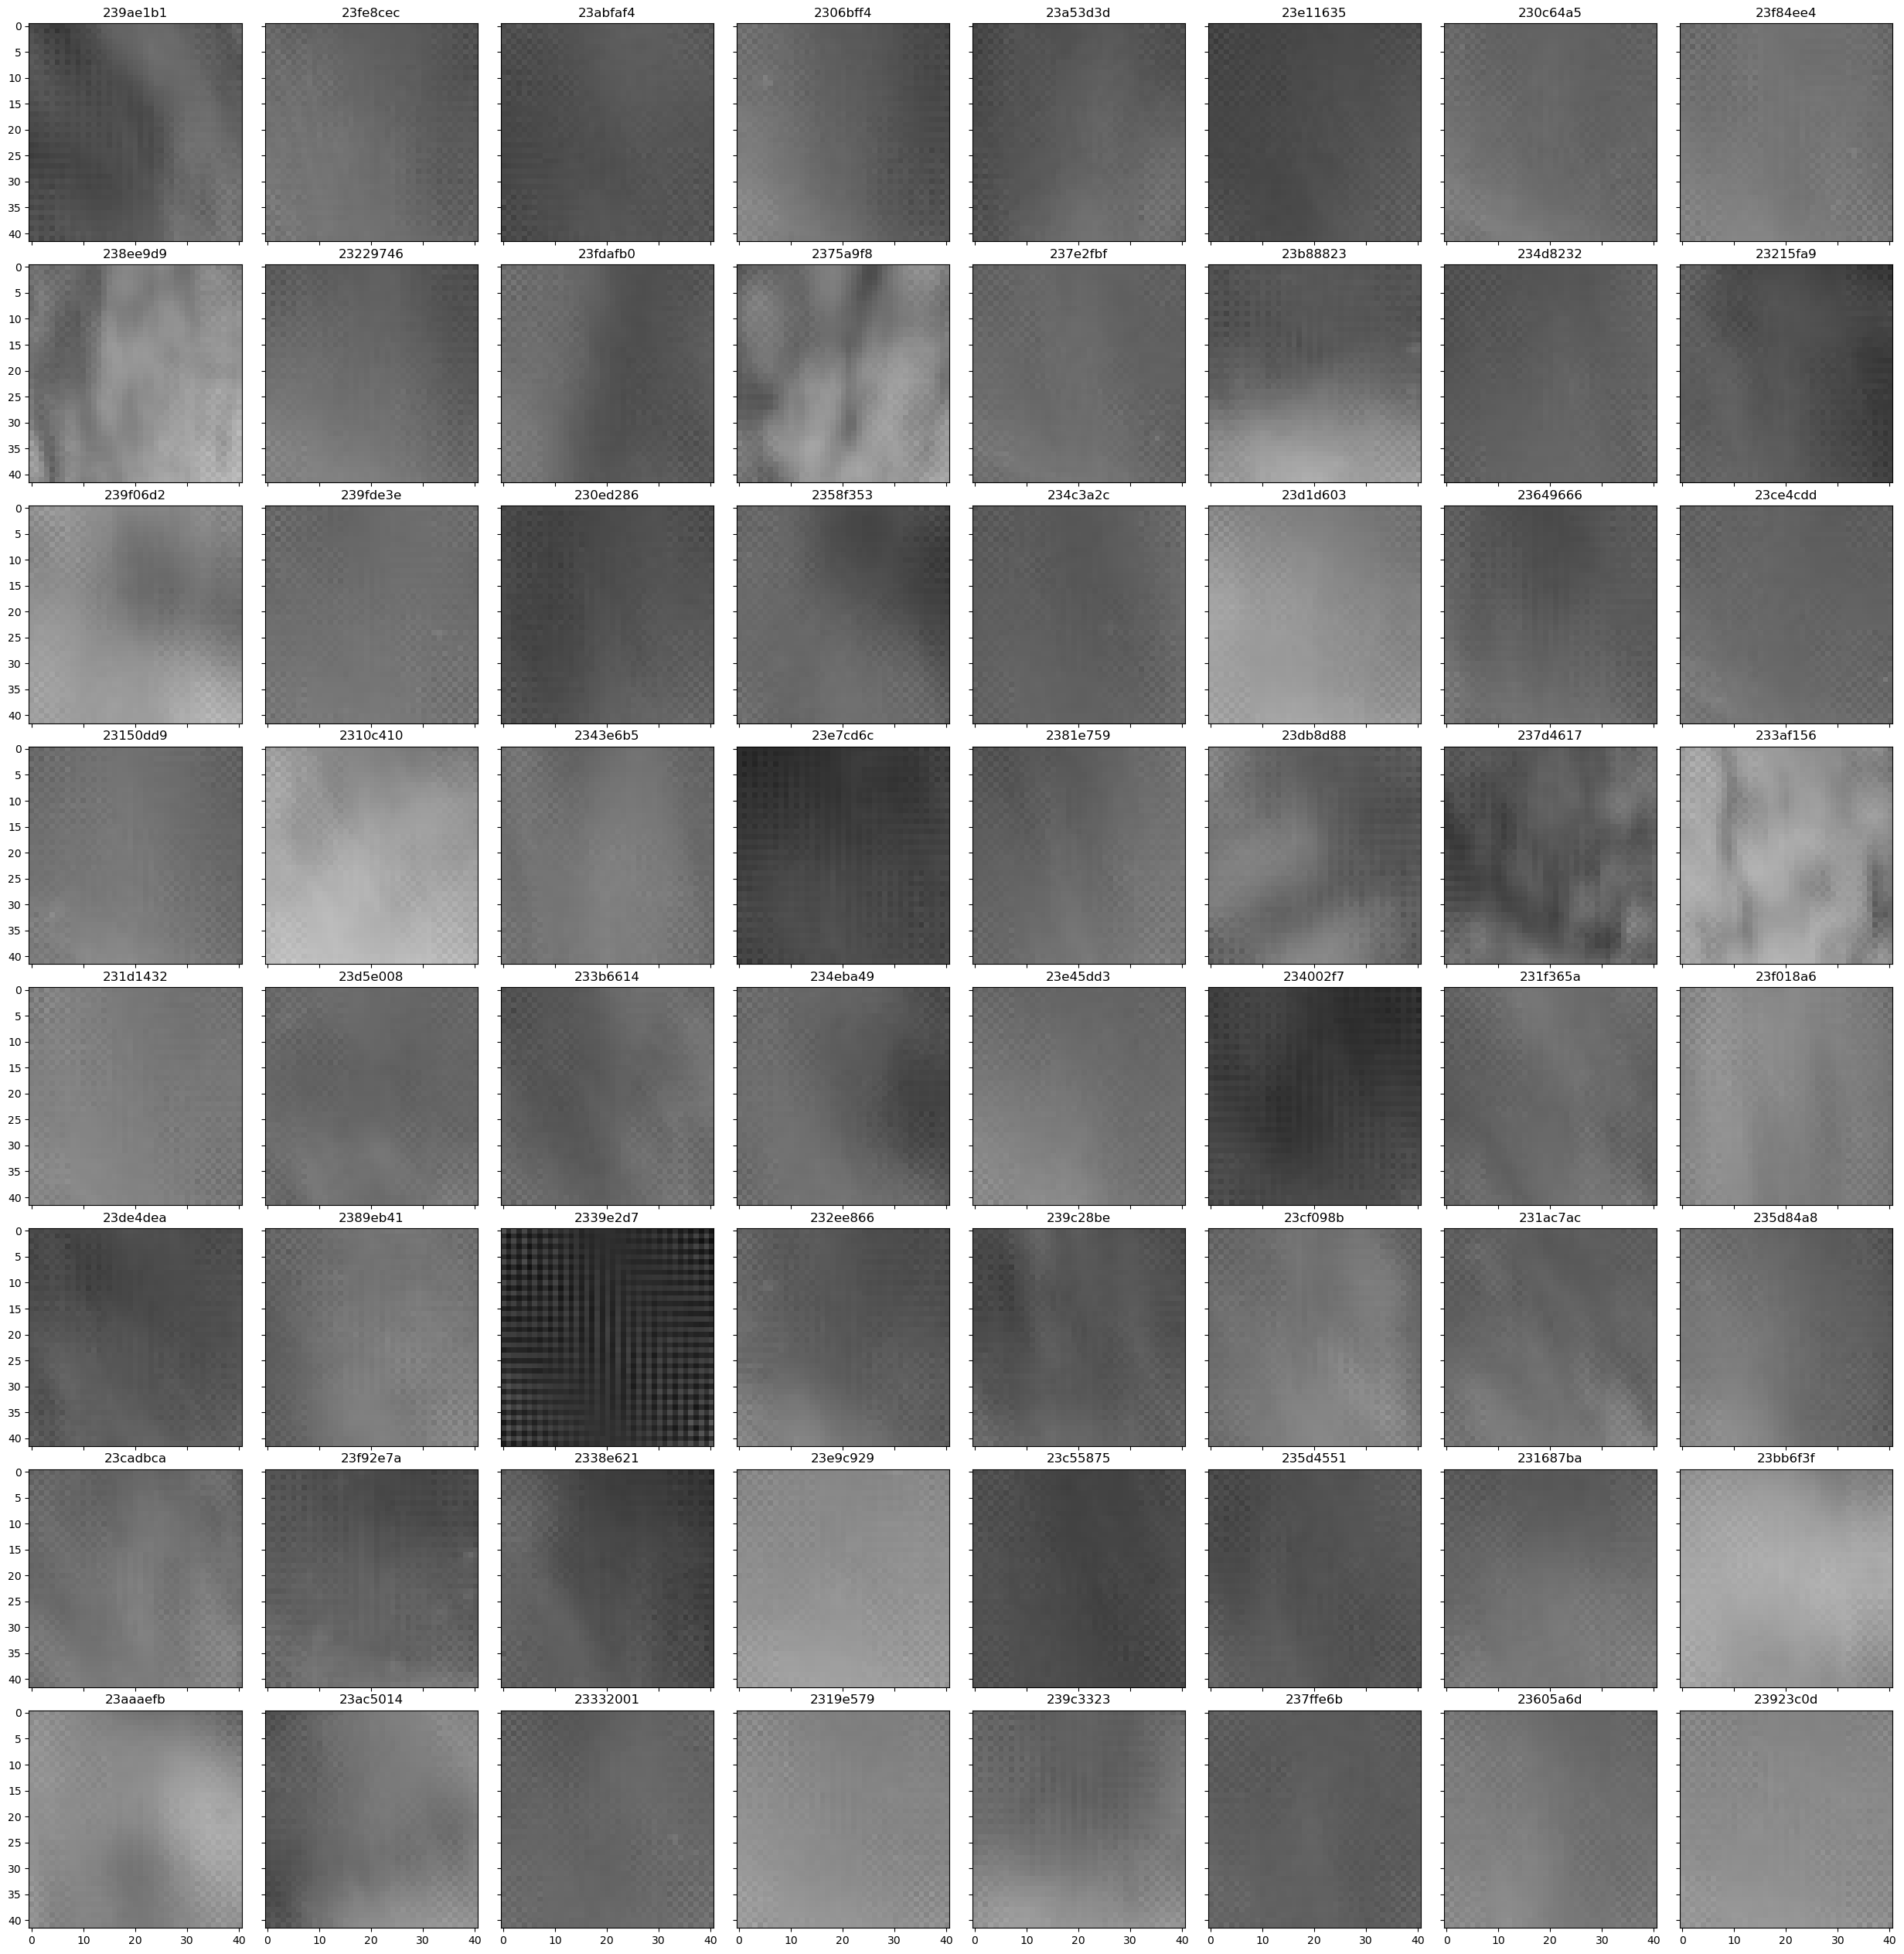

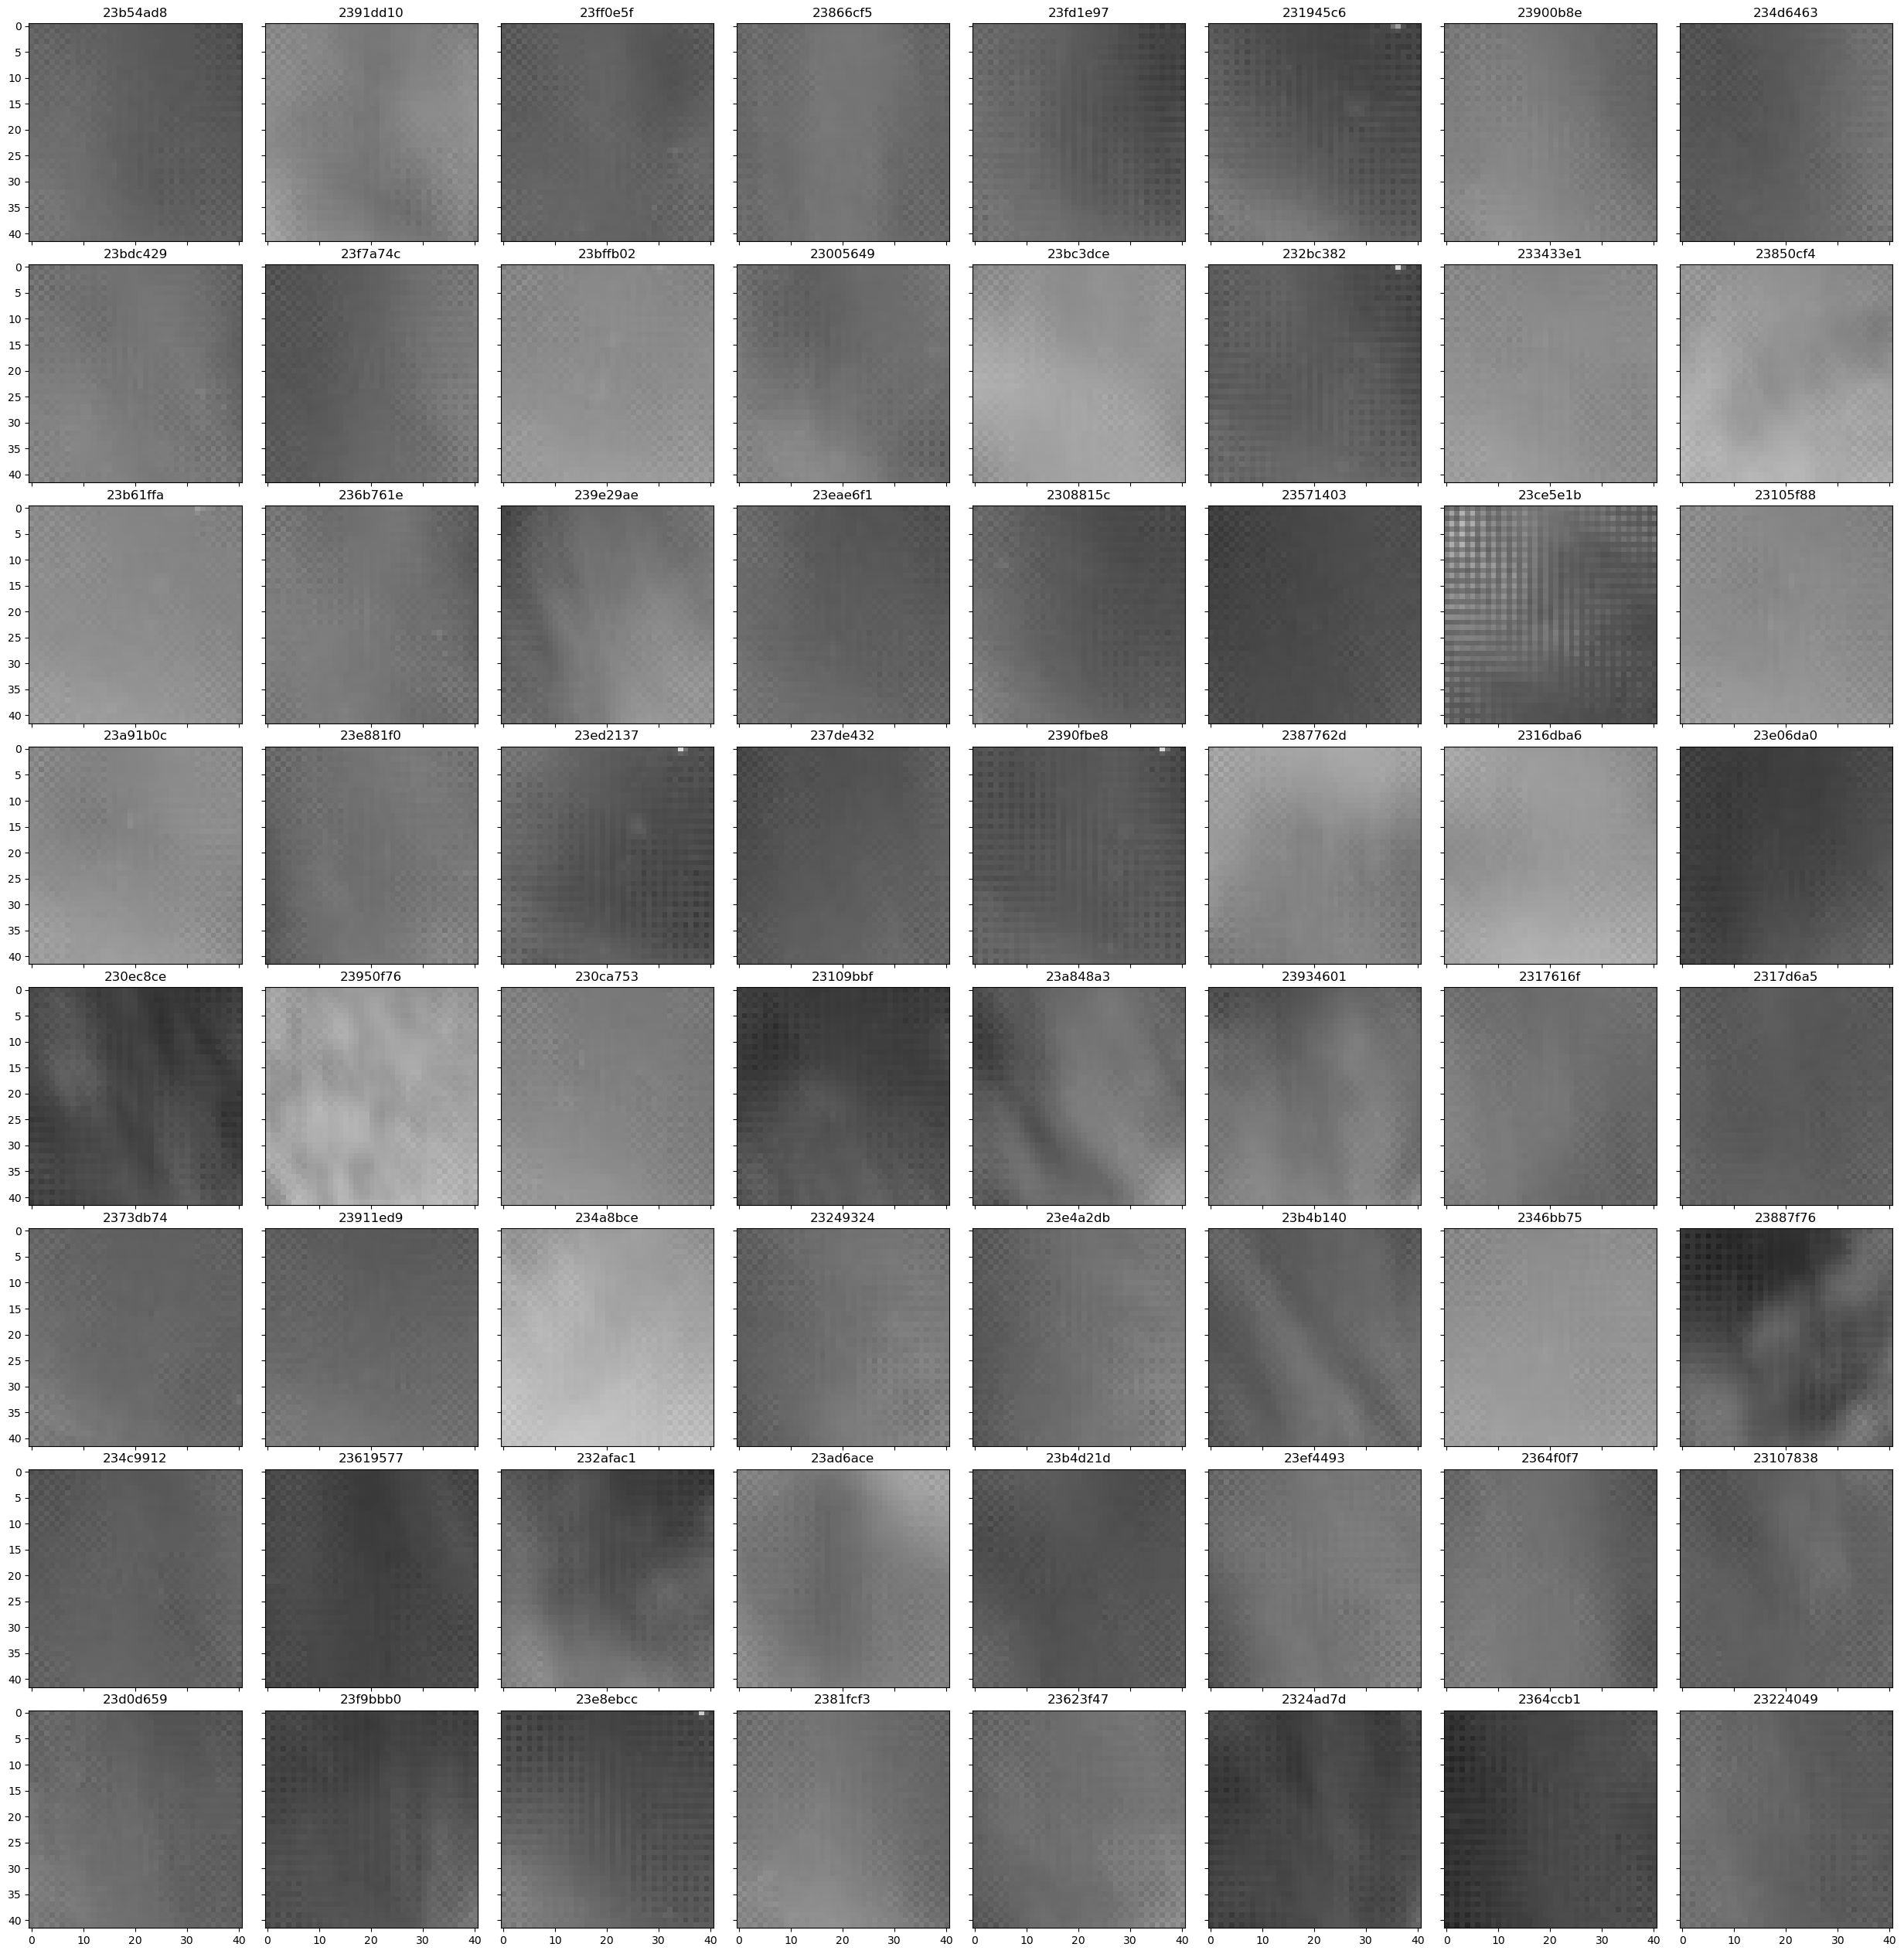

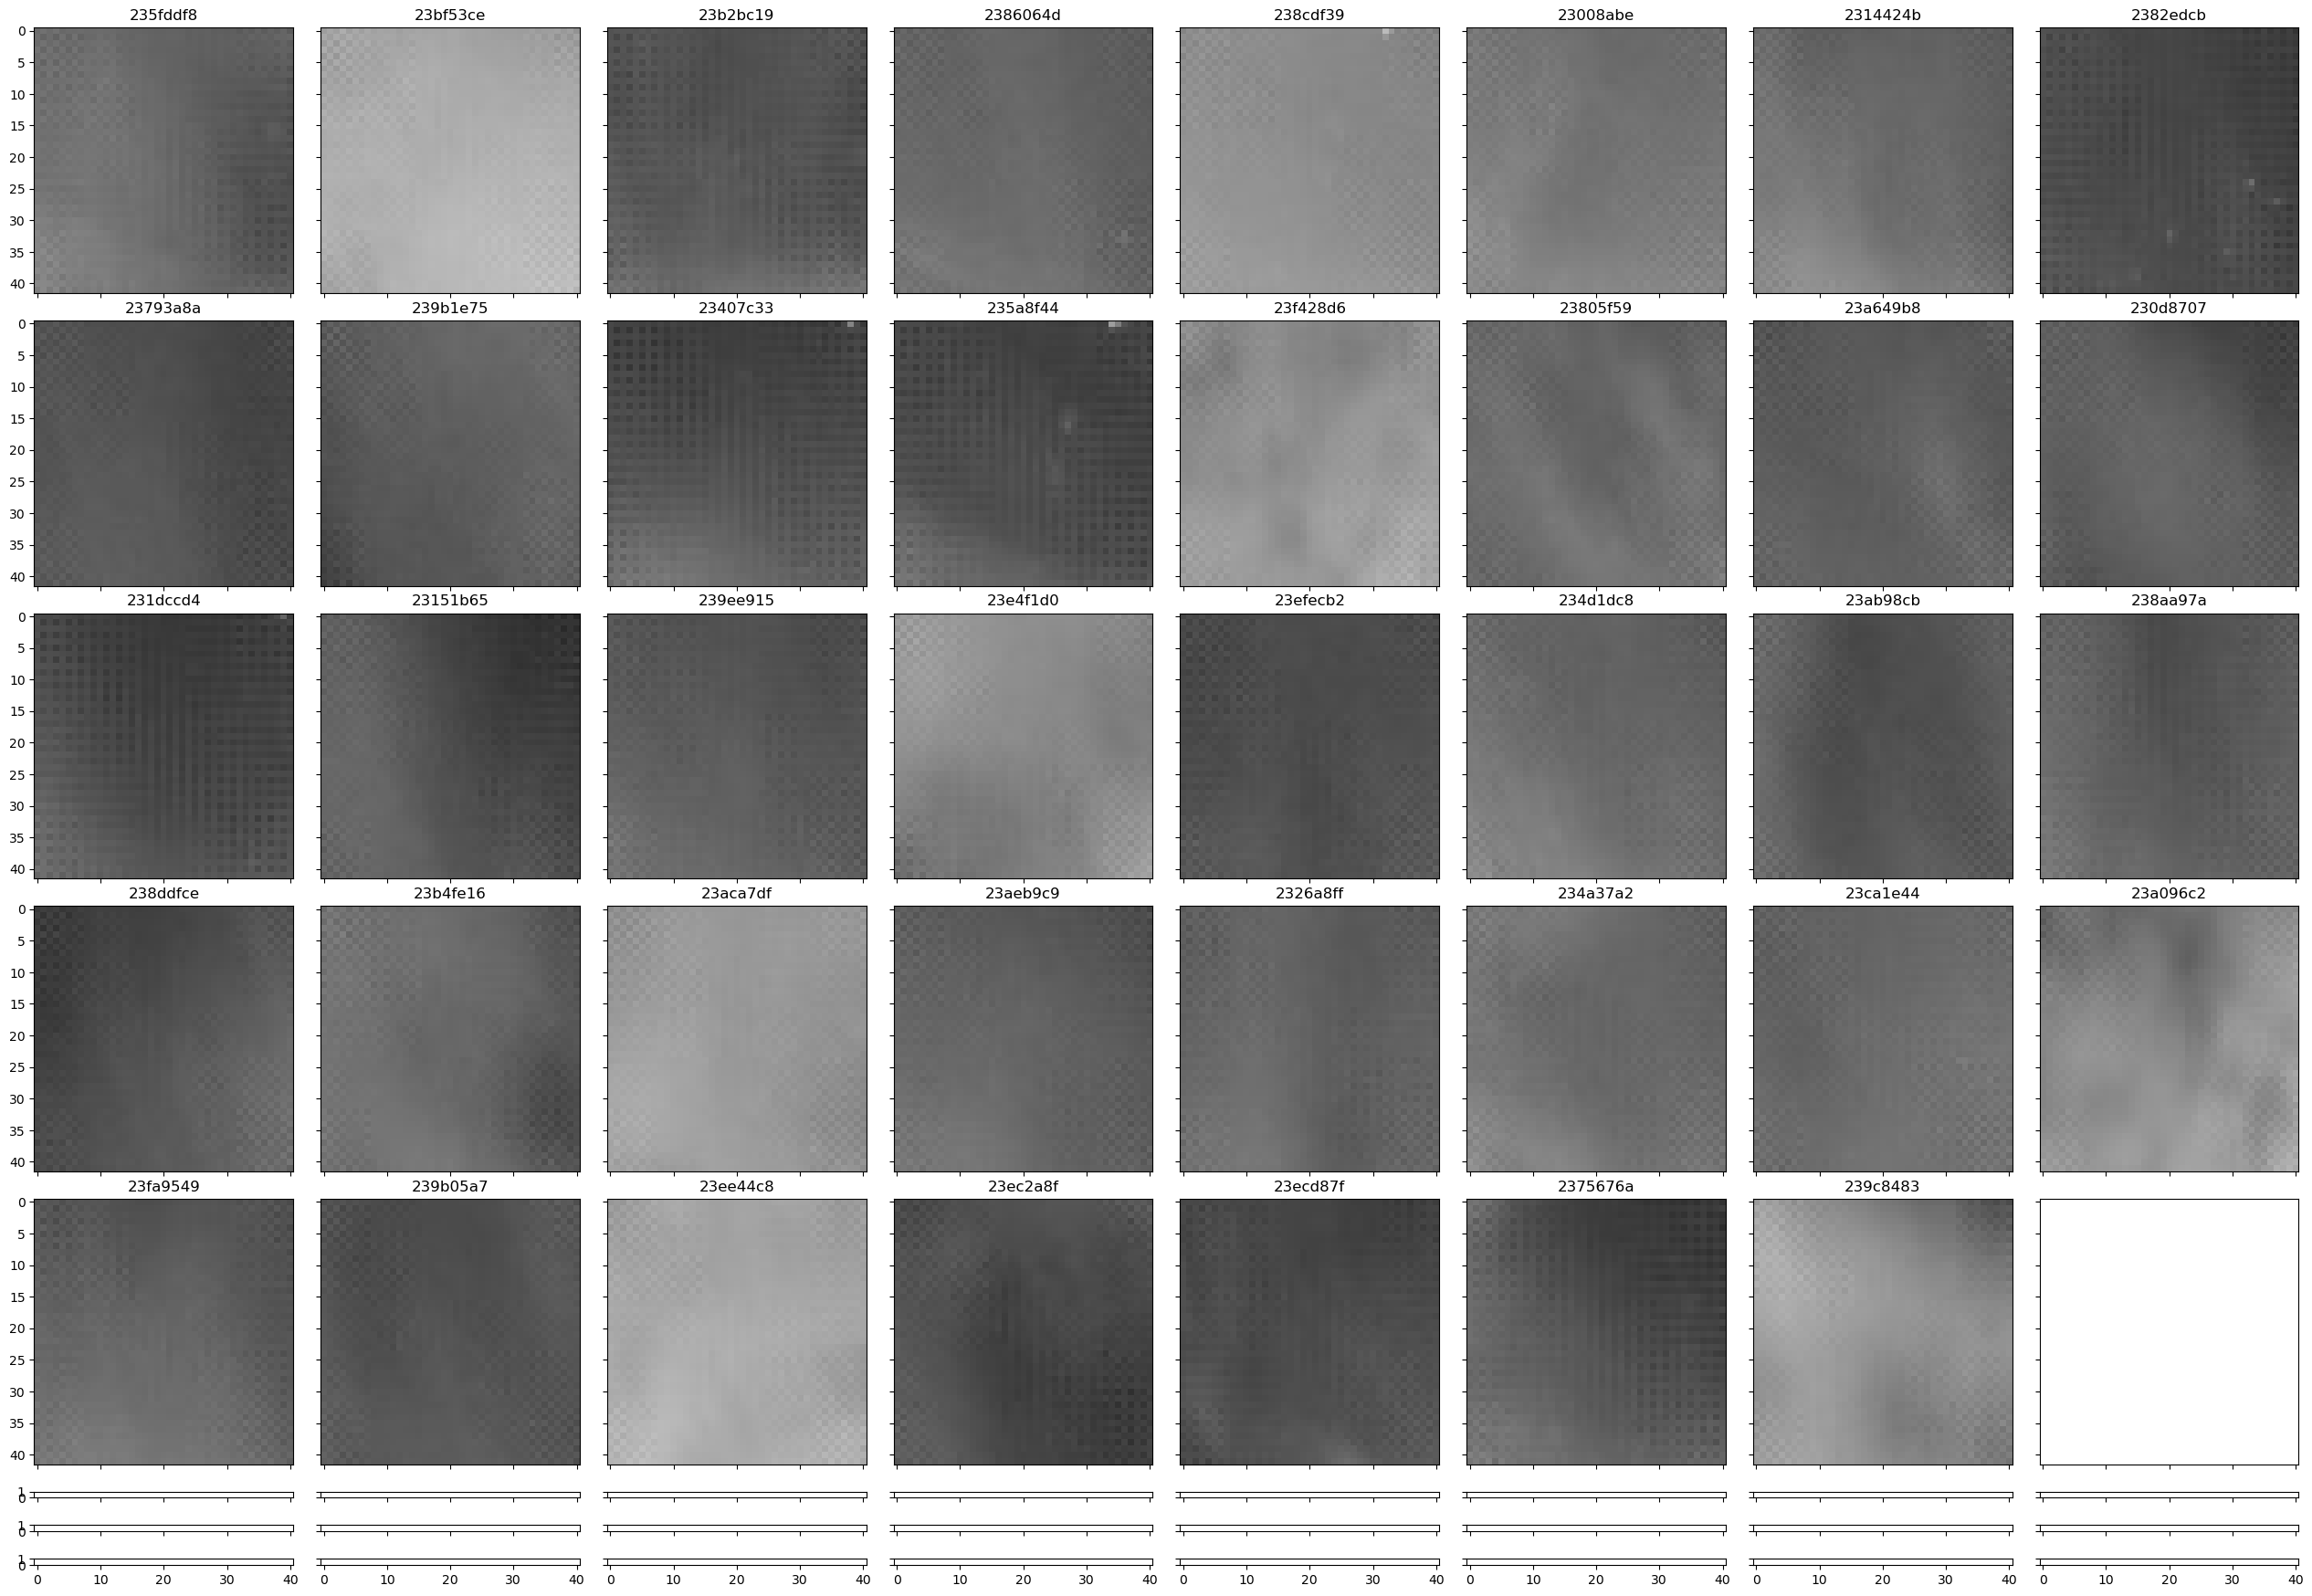

Images you classified as "not_sure":


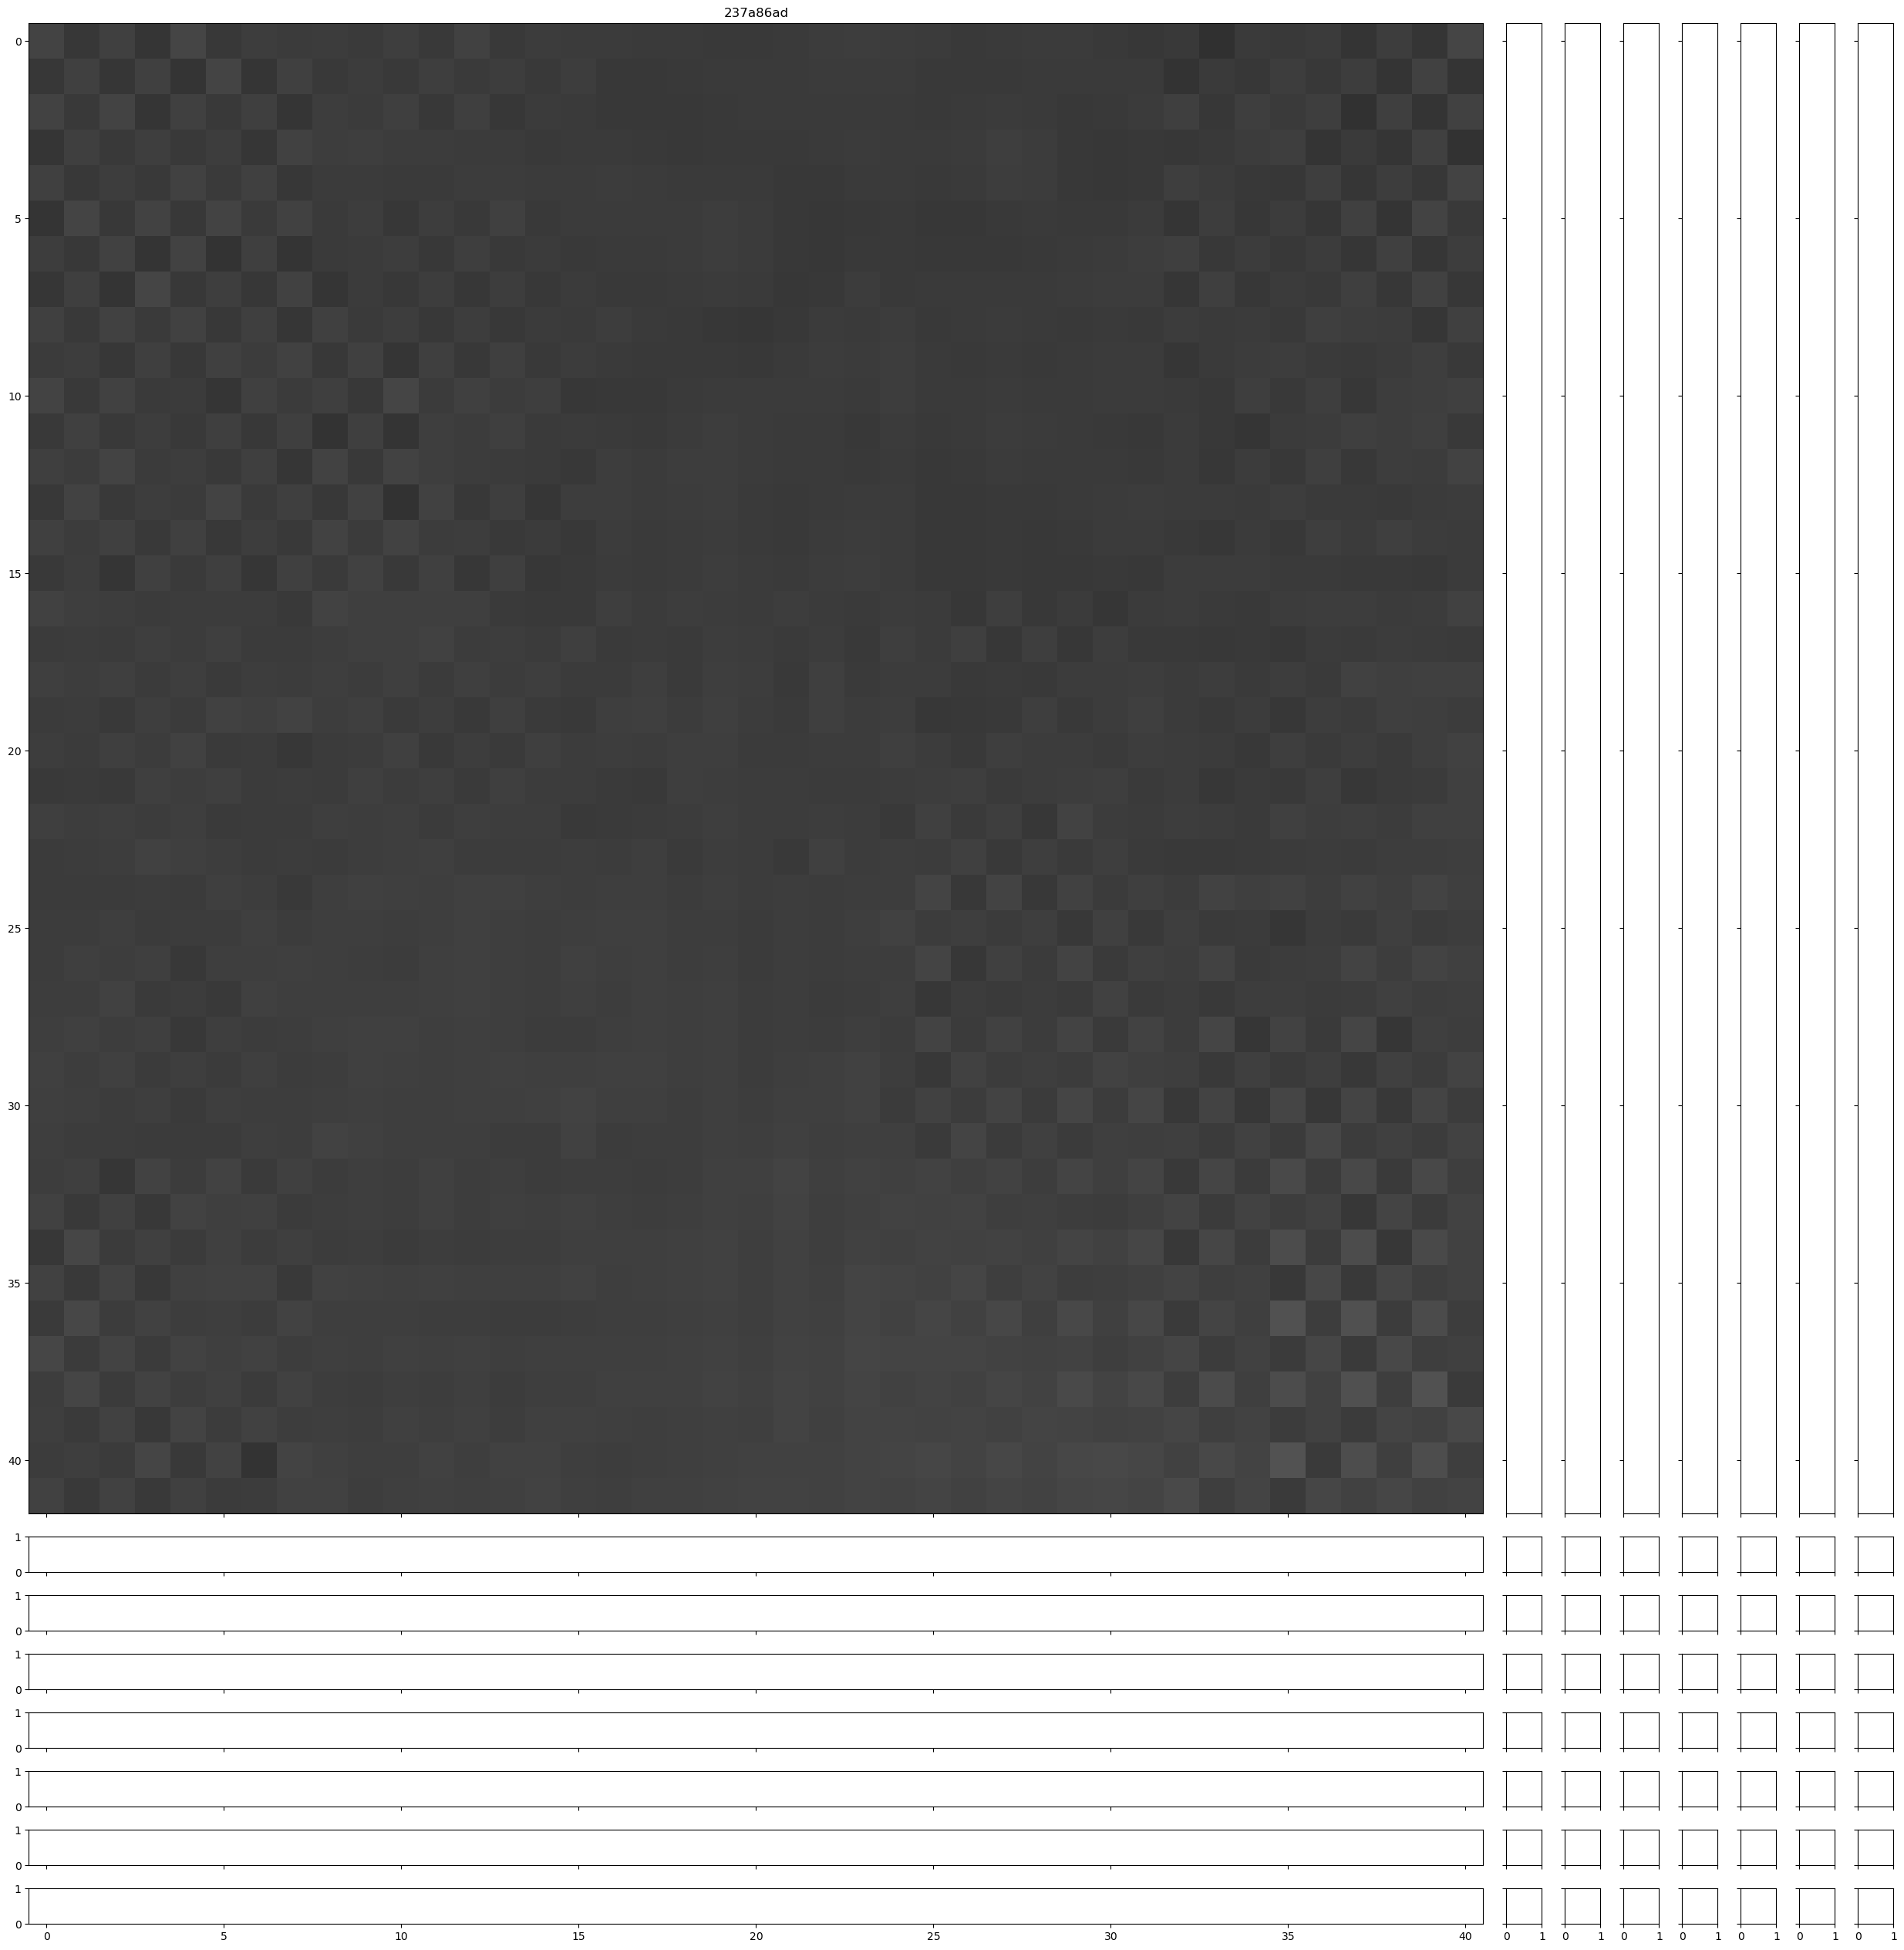

In [136]:
# Run the cell below to preview your labels and write them to file
for key in labels.keys():
    make_img_grid(skycam_img_metadata, int(key))

In [138]:
# Data saving routines

def get_data_out_dir(user_uid):
    return f'{user_uid}_data_labels'
            
def write_data(labeled_df, skycam_df, user_df):
    os.mkdir(get_data_out_dir)
    ...